In [1]:
import socket
import sys

"""from my_utils import get_notebook_path
NB = get_notebook_path().split('/')[-1].split('.')[0]
HOST = socket.gethostname()

'"""

NB = 'exp0001'
HOST = 'DESKTOP-M3SEAIN'

NB, HOST

('exp0001', 'DESKTOP-M3SEAIN')

In [2]:
#from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from pathlib import Path
from logzero import logger
from tqdm import tqdm
from collections import OrderedDict
import random
import os
import gc
import shutil
import timm

import mlflow


import torch.optim as optim
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import albumentations as albu

import pickle

import warnings
warnings.simplefilter('ignore')


ROOT_DIR = Path('../')
DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = ROOT_DIR / 'output'
CP_DIR = OUTPUT_DIR / 'checkpoint'

def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def unpickle(filename):
    with open(filename, mode='rb') as fo:
        p = pickle.load(fo)
    return p 

In [3]:

class Config:
    N_LABEL = 10
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 1.0e-05
    MAX_LR = 3.0e-5
    PATIENCE = 15
    EPOCH = 25
    BATCH_SIZE = 16
    SKIP_EVALUATE_NUM = 0
    BACK_BONE = 'tf_efficientnet_b0_ns'
    RUN_FOLD_COUNT = 10
    IMG_SIZE=64
    T_MAX=20
    ETA_MIN=3.0e-7
    SCHEDULER_GAMMA=1.0
    ACCUMULATION_STEMP=2

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=Config.RANDOM_SATE)

In [4]:
#timm.list_models(pretrained=True)

In [5]:
glob.glob(str(DATA_DIR / '*'))

['..\\data\\house_price_test.csv',
 '..\\data\\house_price_train.csv',
 '..\\data\\mnist',
 '..\\data\\mnist_test.csv',
 '..\\data\\mnist_train.csv',
 '..\\data\\titanic_test.csv',
 '..\\data\\titanic_train.csv',
 '..\\data\\tweet_test.csv',
 '..\\data\\tweet_train.csv']

In [6]:
train_df = pd.read_csv(DATA_DIR / 'mnist_train.csv')
test_df = pd.read_csv(DATA_DIR / 'mnist_test.csv')

train_labels = pd.get_dummies(train_df['target'])[:len(train_df)]

In [7]:
img_map = {}
for idx, row in train_df.iterrows():
    img_map[row['file_name']] = cv2.imread(str(DATA_DIR / Path('mnist') / Path(row['file_name'])))
    
for idx, row in test_df.iterrows():
    img_map[row['file_name']] = cv2.imread(str(DATA_DIR / Path('mnist') / Path(row['file_name'])))

In [8]:
def get_augmentation():
    train_transform = [
        #albu.HorizontalFlip(p=0.2),
        #albu.VerticalFlip(p=0.5),
        #albu.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, p=0.5),
        #albu.LongestMaxSize(max_size=Config.IMG_SIZE, always_apply=False),
        albu.RandomResizedCrop(p=0.5, scale=[0.9, 1.0], height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        albu.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=1, border_mode=0, value=0, mask_value=0),
        
        #albu.Cutout(num_holes=3, max_h_size=20, max_w_size=20, fill_value=0, p=0.5),
        
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        #albu.PadIfNeeded(always_apply=True, min_height=Config.IMG_SIZE, min_width=Config.IMG_SIZE, border_mode=2),
        albu.Normalize(),
        #albu.VerticalFlip(p=0.3),
        #albu.ShiftScaleRotate(p=0.3, shift_limit=0.2, scale_limit=0.2, rotate_limit=1, border_mode=0, value=0, mask_value=0),
        #albu.RandomResizedCrop(p=0.5, scale=[0.9, 1.0], height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        #albu.ToSepia(p=0.3),
        #albu.ToGray(p=1)
    ]
    return albu.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        #albu.HorizontalFlip (p=0.5),
        #albu.VerticalFlip(p=0.3),
        #albu.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, p=0.5),
        #albu.LongestMaxSize(max_size=Config.IMG_SIZE, always_apply=False),
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        #albu.PadIfNeeded(always_apply=True, min_height=Config.IMG_SIZE, min_width=Config.IMG_SIZE, border_mode=2),
        #albu.HorizontalFlip(p=0.4),
        albu.Normalize(),
        #albu.VerticalFlip(p=0.3),
        #albu.ShiftScaleRotate(p=0.3, shift_limit=0.2, scale_limit=0.2, rotate_limit=1, border_mode=0, value=0, mask_value=0),
        #albu.RandomResizedCrop(p=0.5, scale=[0.9, 1.0], height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        #albu.ToSepia(p=0.3),
        #albu.ToGray(p=1)
    ]
    return albu.Compose(train_transform)

In [9]:
class CVDataSet(Dataset):
    def __init__(self, df, transforms, labels=None, data_type=None):
        self.df = df
        self.transforms = transforms
        self.labels = labels.to_numpy()
        self.data_type = data_type

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.data_type in ['train', 'valid']:
            target = self.labels[idx]
        else:
            target = -1
            
        img = img_map[self.df.iloc[idx]['file_name']]
        
        augmented = self.transforms(image=img)
        img = augmented['image']
        img = np.moveaxis(img, 2, 0)

        return img, target

In [10]:
class CVNet(nn.Module):
    def __init__(self):
        super(CVNet, self).__init__()

        self.base_model = timm.create_model(Config.BACK_BONE, num_classes=0, pretrained=True, in_chans=3)
        num_features = self.base_model.num_features

        self.cls = nn.Sequential(
            nn.Linear(num_features, int(num_features / 2)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(int(num_features / 2), int(num_features / 4)),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(int(num_features / 4), Config.N_LABEL)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.cls(x)
        return x

In [11]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=''):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            logger.info(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            
        #if os.path.exists(CP_DIR / f'checkpoint_{NB}_{fold}.pt'):
        #    shutil.move(CP_DIR / f'checkpoint_{NB}_{fold}.pt', CP_DIR / f'checkpoint_{NB}_{fold}-2.pt')
        torch.save(model.state_dict(), CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt')
        self.val_loss_min = val_loss

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

====== 0 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.06it/s]
[I 220918 18:38:37 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1050
[I 220918 18:38:37 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (inf --> -0.105000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.46it/s]
[I 220918 18:38:43 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1250
[I 220918 18:38:43 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.105000 --> -0.125000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.86it/s]
[I 220918 18:38:48 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1350
[I 220918 18:38:48 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.125000 --> -0.135000).  Saving model ...
100%|█████████████████████████████████████████████████████████████████

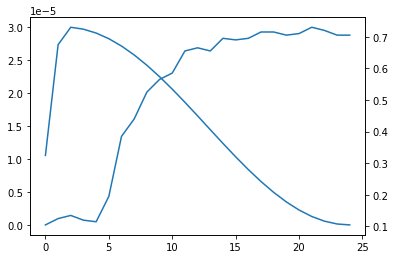

====== 1 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.49it/s]
[I 220918 18:40:39 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.0800
[I 220918 18:40:39 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (inf --> -0.080000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 60.39it/s]
[I 220918 18:40:44 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1500
[I 220918 18:40:44 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.080000 --> -0.150000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.27it/s]
[I 220918 18:40:49 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1300
[I 220918 18:40:49 <ipython-input-11-69ff1a595f6e>:20] EarlyStopping counter: 1 out of 15
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:0

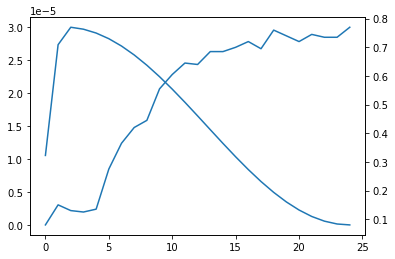

====== 2 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 54.76it/s]
[I 220918 18:42:40 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1200
[I 220918 18:42:40 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (inf --> -0.120000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.06it/s]
[I 220918 18:42:45 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1100
[I 220918 18:42:45 <ipython-input-11-69ff1a595f6e>:20] EarlyStopping counter: 1 out of 15
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.29it/s]
[I 220918 18:42:50 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.0900
[I 220918 18:42:50 <ipython-input-11-69ff1a595f6e>:20] EarlyStopping counter: 2 out of 15
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 57.58it/s]
[I 220918 18:42:55 <ip

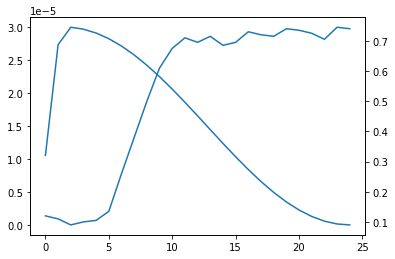

====== 3 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.50it/s]
[I 220918 18:44:41 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1000
[I 220918 18:44:41 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (inf --> -0.100000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 56.42it/s]
[I 220918 18:44:46 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1100
[I 220918 18:44:46 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.100000 --> -0.110000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.02it/s]
[I 220918 18:44:51 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1150
[I 220918 18:44:51 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.110000 --> -0.115000).  Saving model ...
100%|█████████████████████████████████████████████████████████████████

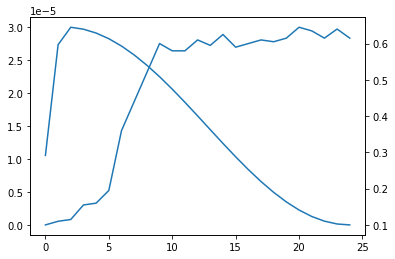

====== 4 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.50it/s]
[I 220918 18:46:42 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.0900
[I 220918 18:46:42 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (inf --> -0.090000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 58.56it/s]
[I 220918 18:46:46 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1300
[I 220918 18:46:46 <ipython-input-11-69ff1a595f6e>:31] Validation loss decreased (-0.090000 --> -0.130000).  Saving model ...
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 62.04it/s]
[I 220918 18:46:51 <ipython-input-13-eba0bd8ad1bb>:74] acc:0.1150
[I 220918 18:46:51 <ipython-input-11-69ff1a595f6e>:20] EarlyStopping counter: 1 out of 15
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:0

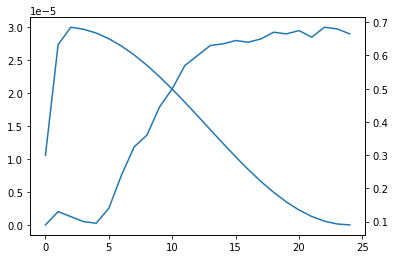

In [13]:
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'====== {fold} ======')

    net = CVNet()
    net.to(device)

    #criterion = nn.MSELoss()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(net.parameters(), lr=Config.LR, weight_decay=1.0e-02)    

    train, valid = train_df.iloc[train_index], train_df.iloc[test_index]
    y_train, y_valid = train_labels.iloc[train_index], train_labels.iloc[test_index]
    
    train_dataset = CVDataSet(train, get_augmentation(), labels=y_train, data_type='train')
    valid_dataset = CVDataSet(valid, get_test_augmentation(), labels=y_valid, data_type='valid')

    trainloader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=True)
    validloader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE)

    early_stopping = EarlyStopping(patience=Config.PATIENCE, verbose=True, fold=fold)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=Config.EPOCH, steps_per_epoch=len(trainloader), max_lr=Config.MAX_LR, pct_start= 0.1, anneal_strategy='cos', div_factor= 1.0e+3, final_div_factor= 1.0e+3)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.T_MAX, eta_min=Config.ETA_MIN)
    # scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=int((len(trainloader) * Config.EPOCH) / 5), cycle_mult=1.0, max_lr=Config.LR, min_lr=Config.ETA_MIN, warmup_steps=int((len(trainloader) * Config.EPOCH) / 50), gamma=Config.SCHEDULER_GAMMA)

    val_metrics = []
    learning_rates = []

    for epoch in range(Config.EPOCH):

        running_loss = 0.0
        train_rmse_list = []
        n_iter = len(trainloader)
        with tqdm(enumerate(trainloader), total=n_iter) as pbar:
            for i, (img, target) in pbar:

                net.train()
                # zero the parameter gradients
                #optimizer.zero_grad()

                img, target = img.to(device).float(), target.to(device).float()
                
                outputs = net(img)
                
                loss = criterion(outputs, target)
                
                loss.backward()
                optimizer.step()
                net.zero_grad()

                # print statistics
                running_loss += loss.item()

                outputs_np = outputs.to('cpu').detach().numpy().copy()

                pbar.set_postfix(OrderedDict(
                    epoch="{:>10}".format(epoch), loss="{:.4f}".format(loss.item())
                ))
                scheduler.step()

        val_preds = []
        n_iter_val = len(validloader)
        for i, (img, target) in tqdm(enumerate(validloader), total=n_iter_val):
            net.eval()

            with torch.no_grad():
                img, pawpularities = img.to(device).float(), target.to(device).float()
                outputs = net(img)
                outputs = outputs.sigmoid() * 100
                outputs_np = outputs.to('cpu').detach().numpy().copy()
                val_preds.append(outputs_np)

        acc = accuracy_score(np.argmax(y_valid.to_numpy(), axis=1), np.argmax(np.vstack(val_preds), axis=1))
        logger.info('acc:{:.4f}'.format(acc))

        lr = optimizer.param_groups[0]['lr']

        val_metrics.append(acc)
        learning_rates.append(lr)

        early_stopping(-acc, net)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{NB}_{fold}.pt'))
            cv_scores[f'cv{fold}'] = early_stopping.best_score
            break

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(learning_rates)
    ax2 = ax1.twinx()
    ax2.plot(val_metrics)
    plt.show()

    del net, validloader, trainloader, train_dataset, valid_dataset
    torch.cuda.empty_cache()
    gc.collect()


In [18]:
cv_scores = {}
oof = np.zeros((len(train_df), Config.N_LABEL))
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df['target'])):
    print(f'\r\n====== {fold} ======')

    net = CVNet()
    net.to(device)

    valid = train_df.iloc[test_index]
    y_valid = train_labels.iloc[test_index]

    valid_dataset = CVDataSet(valid, get_test_augmentation(), labels=y_valid, data_type='valid')

    validloader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE)

    preds = []
    for i, (img, target) in tqdm(enumerate(validloader), total=len(validloader)):
        net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))
        net.eval()

        with torch.no_grad():

            img, target = img.to(device).float(), target.to(device).float()
            outputs = net(img)
            outputs_np = outputs.to('cpu').detach().numpy().copy()
            preds.append(outputs_np)

    acc = accuracy_score(np.argmax(y_valid.to_numpy(), axis=1), np.argmax(np.vstack(preds), axis=1))
    print(acc)

    oof[test_index] = np.vstack(preds)
    cv_scores[f'cv{fold}'] = acc

    del net, valid_dataset, validloader
    torch.cuda.empty_cache()
    gc.collect()

print(np.mean([v for k, v in cv_scores.items()]))
accuracy_score(np.argmax(train_labels.to_numpy(), axis=1), np.argmax(oof, axis=1))


====== 0 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.56it/s]


0.73

====== 1 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.66it/s]


0.77

====== 2 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.67it/s]


0.745

====== 3 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.62it/s]


0.645

====== 4 ======


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.59it/s]


0.685
0.7150000000000001


0.715

In [19]:
oof_df = train_df.copy()
oof_df['oof'] = np.argmax(oof, axis=1)
oof_file_name = str(OUTPUT_DIR / f'oof_{HOST}_{NB}.csv')
oof_df.to_csv(oof_file_name, index=False)
oof_df

,target,file_name,oof
0,0,0.png,0
1,1,1.png,1
2,2,2.png,5
3,3,3.png,3
4,4,4.png,4
...,...,...,...
995,7,995.png,7
996,6,996.png,0
997,8,997.png,9
998,4,998.png,4


In [23]:
"""param_dict = {k:v for k, v in vars(Config).items() if not k.startswith('__')}

remote_server_uri = "http://192.168.1.99:5000/"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://192.168.1.99:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio-access-key"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio-secret-key"

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("template")
with mlflow.start_run():
    mlflow.set_tag('NB', NB)
    #mlflow.set_tag('DESCRIPTION', description)
    mlflow.set_tag('HOST', HOST)

    mlflow.log_params(param_dict)
    #mlflow.log_param('loss', type(criterion))
    #mlflow.log_param('optimizer', type(optimizer))
    #mlflow.log_param('scheduler', type(scheduler))

    mlflow.log_metrics(cv_scores)
    mlflow.log_metric('cv_score_mean', np.mean([v for k, v in cv_scores.items()]))

    mlflow.log_artifact(get_notebook_path())
    #mlflow.log_artifact(sub_file_name)
    mlflow.log_artifact(oof_file_name)"""

'param_dict = {k:v for k, v in vars(Config).items() if not k.startswith(\'__\')}\n\nremote_server_uri = "http://192.168.1.99:5000/"\nos.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://192.168.1.99:9000"\nos.environ["AWS_ACCESS_KEY_ID"] = "minio-access-key"\nos.environ["AWS_SECRET_ACCESS_KEY"] = "minio-secret-key"\n\nmlflow.set_tracking_uri(remote_server_uri)\nmlflow.set_experiment("template")\nwith mlflow.start_run():\n    mlflow.set_tag(\'NB\', NB)\n    #mlflow.set_tag(\'DESCRIPTION\', description)\n    mlflow.set_tag(\'HOST\', HOST)\n\n    mlflow.log_params(param_dict)\n    #mlflow.log_param(\'loss\', type(criterion))\n    #mlflow.log_param(\'optimizer\', type(optimizer))\n    #mlflow.log_param(\'scheduler\', type(scheduler))\n\n    mlflow.log_metrics(cv_scores)\n    mlflow.log_metric(\'cv_score_mean\', np.mean([v for k, v in cv_scores.items()]))\n\n    mlflow.log_artifact(get_notebook_path())\n    #mlflow.log_artifact(sub_file_name)\n    mlflow.log_artifact(oof_file_name)'

In [28]:
y_preds = np.zeros((len(test_df), Config.N_LABEL))

test_dataset = CVDataSet(test_df, get_test_augmentation(), labels=pd.DataFrame(), data_type='test')
testloader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

for fold in range(Config.N_FOLD):

    net = CVNet()
    net.to(device)
    print(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt')
    net.load_state_dict(torch.load(CP_DIR / f'checkpoint_{HOST}_{NB}_{fold}.pt'))

    fold_preds = []
    for i, (inputs, target) in tqdm(enumerate(testloader), total=len(testloader)):
        net.eval()

        with torch.no_grad():
            
            inputs, target = inputs.to(device).float(), target.to(device).float()
            outputs = net(inputs)
            outputs_np = outputs.to('cpu').detach().numpy().copy()
            
            fold_preds.append(outputs_np)
    
    y_preds += np.vstack(fold_preds) / Config.N_FOLD

..\output\checkpoint\checkpoint_DESKTOP-M3SEAIN_exp0001_0.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.91it/s]


..\output\checkpoint\checkpoint_DESKTOP-M3SEAIN_exp0001_1.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.65it/s]


..\output\checkpoint\checkpoint_DESKTOP-M3SEAIN_exp0001_2.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.17it/s]


..\output\checkpoint\checkpoint_DESKTOP-M3SEAIN_exp0001_3.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 57.92it/s]


..\output\checkpoint\checkpoint_DESKTOP-M3SEAIN_exp0001_4.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.75it/s]


In [30]:
test_df['target'] = np.argmax(y_preds, axis=1)
#submission_df = test_df[['Id', 'Pawpularity']]
#submission_df.to_csv('submission.csv', index=False)

In [32]:
y_preds

array([[-2.50560302, -1.36711237, -2.19059864, ..., -2.38733649,
        -2.33723795, -2.61248857],
       [-2.39498678, -2.10195184, -2.35449614, ..., -2.42560722,
        -2.61050746, -2.43985288],
       [-0.92575102, -2.63626322, -2.56343669, ..., -2.70200583,
        -2.17960021, -2.11828265],
       ...,
       [-1.98020738, -2.02579054, -1.76224646, ..., -1.8139703 ,
        -1.67312056, -1.62589565],
       [-1.63924962, -3.09014109, -2.21068111, ..., -2.05218002,
        -2.0326336 , -1.1425743 ],
       [-1.28770913, -1.73597354, -1.5082335 , ..., -1.7713753 ,
        -1.48767224, -1.57573569]])